In [1]:
import pandas as pd
import numpy as np
import os

from xgboost import XGBClassifier
# scikit learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle, resample
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_curve,
    auc,
    f1_score,
)

from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier

In [2]:
malicious_features = pd.read_pickle("data/malicious_features.pkl")
benign_features = pd.read_pickle("data/benign_features.pkl")

In [3]:
malicious_features.pop("Payload")
benign_features.pop("Payload")

4           Raw
5           Raw
6           Raw
7           Raw
26          Raw
          ...  
38585    Radius
38586    Radius
38587    Radius
38588    Radius
38589    Radius
Name: Payload, Length: 18615, dtype: object

# Labeling
We label and concatenate benign and malicious before one-hot because there are different ports in each dataset and concatenating the two after one hot will not work with different columns.

In [4]:
# add labels, 0 for benign, 1 for malicious
malicious_features["Labels"] = 1
benign_features["Labels"] = 0

In [5]:
# concatenate dataframes
data_df = pd.concat(
    [malicious_features, benign_features], ignore_index=True
)

In [6]:
# randomize the data. TODO: is this needed??
data_df = shuffle(data_df)

# Downsampling
Balancing the class that has the most data points, in our case the malicious class.

In [7]:
# Assuming you have your data loaded into a Pandas DataFrame called 'data'

# Separate majority and minority classes
majority_class = data_df[data_df["Labels"] == 1]
minority_class = data_df[data_df["Labels"] == 0]

# Downsample majority class
downsampled_majority = resample(
    majority_class,
    replace=False,  # sample without replacement
    n_samples=len(minority_class),  # to match minority class
    random_state=42,
)  # reproducible results

# Combine minority class with downsampled majority class
downsampled_data = pd.concat([downsampled_majority, minority_class])

# Shuffle the data
downsampled_data = downsampled_data.sample(frac=1, random_state=42)

# Now downsampled_data contains your downsampled dataset

# Model Training
- We use some characteristic models for demonstration purposes. Models need to be tuned by exploring their hyperparameters and compared in order to pick the best one for the application.
  - xgboost
  - NN
  - k-NN
  - Random Forest
- k-fold cross validation
  - split the data in k parts
  - use one part for testing, the other k-1 parts for training the model
  - repeat for all the combinations of k parts using a different one for testing, the other k-1 for training the model

In [8]:
# after feature engineering, drop all the columns that are unnecessary
downsampled_data = downsampled_data.drop(["Source Port", "Destination Port"], axis=1)

In [9]:
# store the features and labels in separate dataframes
X = downsampled_data.drop("Labels", axis=1)
y = downsampled_data["Labels"]

In [10]:
# convert data to array
data_array = downsampled_data.to_numpy()

## Model selection

We picked three characteristic models:
- Decision Tree
- Random Forest
- XGB

In [11]:
decision_tree = DecisionTreeClassifier()

In [12]:
# Random Forest Classifier
rf = RandomForestClassifier(max_depth=2, random_state=0)

In [13]:
# XGBoost
xgb = XGBClassifier(
    n_estimators=2, max_depth=2, learning_rate=1, objective="binary:logistic"
)

# Model Evaluation

## Metrics
We compare all models using the following metrics:
- accuracy: Accuracy is the proportion of correct predictions to the total number of predictions.
- precision: Precision measures the proportion of true positives to the total predicted positives.
- recall: Recall (also known as sensitivity or true positive rate) measures the proportion of true positives to the total actual positives.
- f1 score

Note: we use the models out of box without fine tuning them.

In [14]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

In [15]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return accuracy, precision, recall, f1

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
dt_trained = train_model(decision_tree, X_train, y_train)
dt_accuracy, dt_precision, dt_recall, dt_f1 = evaluate_model(decision_tree, X_test, y_test)
print("Accuracy:", dt_accuracy)
print("Precision:", dt_precision)
print("Recall:", dt_recall)
print("F1 Score:", dt_f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


In [18]:
rf_trained = train_model(rf, X_train, y_train)
rf_accuracy, rf_precision, rf_recall, rf_f1 = evaluate_model(
    rf, X_test, y_test
)
print("Accuracy:", rf_accuracy)
print("Precision:", rf_precision)
print("Recall:", rf_recall)
print("F1 Score:", rf_f1)

Accuracy: 0.9873757722266989
Precision: 0.9943533207851573
Recall: 0.9806417395916203
F1 Score: 0.9874499332443257


In [19]:
xgb_trained = train_model(xgb, X_train, y_train)
xgb_accuracy, xgb_precision, xgb_recall, xgb_f1 = evaluate_model(xgb, X_test, y_test)
print("Accuracy:", xgb_accuracy)
print("Precision:", xgb_precision)
print("Recall:", xgb_recall)
print("F1 Score:", xgb_f1)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


## Confusion matrix

A confusion matrix is a table that visualizes the performance of a classification model by showing the counts of true positive, true negative, false positive, and false negative predictions.

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix


def plot_confusion_matrix(model, X, y):
    # Initialize an empty confusion matrix
    cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)

    # Perform k-fold cross-validation and accumulate the confusion matrix
    predictions = cross_val_predict(model, X, y, cv=5)  # Change cv value as needed
    cm += confusion_matrix(y, predictions)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

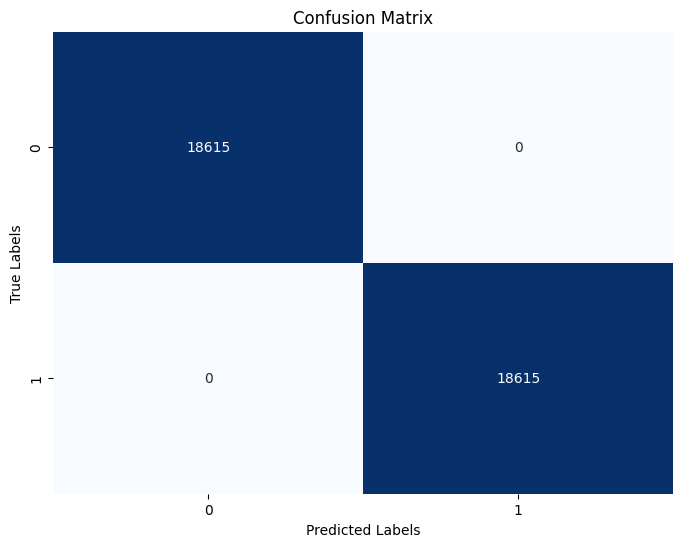

In [21]:
plot_confusion_matrix(decision_tree, X, y)

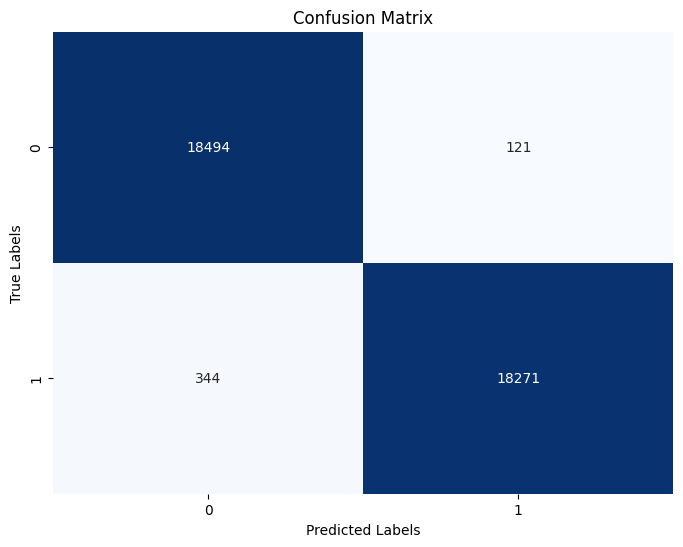

In [22]:
plot_confusion_matrix(rf, X, y)

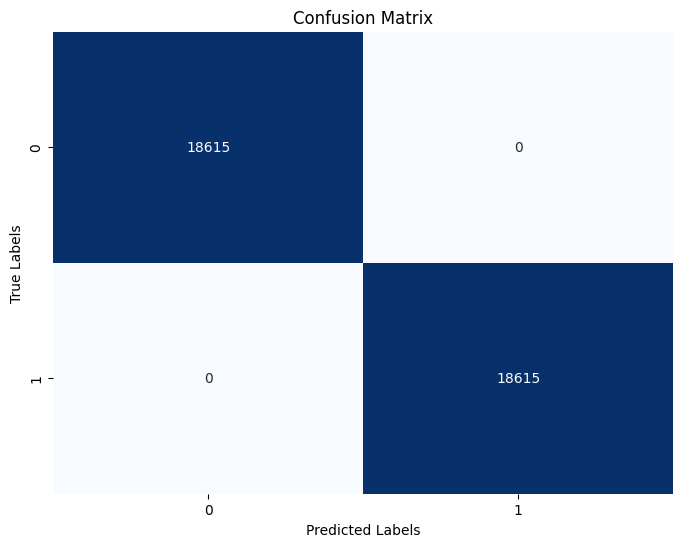

In [23]:
plot_confusion_matrix(xgb, X, y)

## ROC curve

Use a ROC curve to visualize the model evaluation:
- The X-axis indicates the False Positive Rate
- The Y-axis indicates the True Positive Rate
- The higher the area under the curve the better the model performance
- The diagonal line indicates the performance of a random classifier
- Performance at the top level corner indicates high TPR with low TPR for the same threshold

In [24]:
def plot_roc_curve(model, X, y, n_folds=5):
    # Initialize variables to store false positive rate and true positive rate for each fold
    mean_fpr = np.linspace(0, 1, 100)
    tpr_sum = 0

    X = X.values
    y = y.values

    # Create k-fold cross-validation iterator
    cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

    plt.figure(figsize=(8, 6))

    for train, test in cv.split(X, y):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]

        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]

        fpr, tpr, _ = roc_curve(y_test, y_prob)
        tpr_sum += np.interp(mean_fpr, fpr, tpr)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

    mean_tpr = tpr_sum / n_folds
    plt.plot([0, 1], [0, 1], linestyle="--", lw=2, color="r", label="Random Chance")
    plt.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        lw=2,
        label="Mean ROC (AUC = {:.2f})".format(auc(mean_fpr, mean_tpr)),
    )

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend(loc="lower right")
    plt.show()

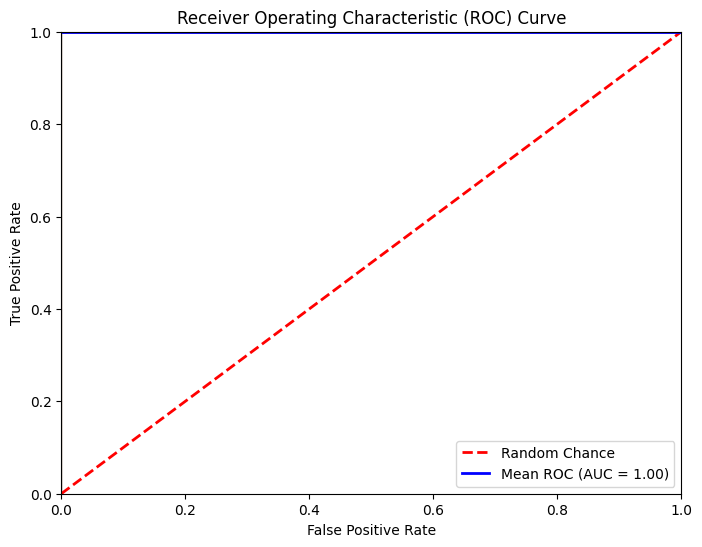

In [25]:
plot_roc_curve(decision_tree, X, y)

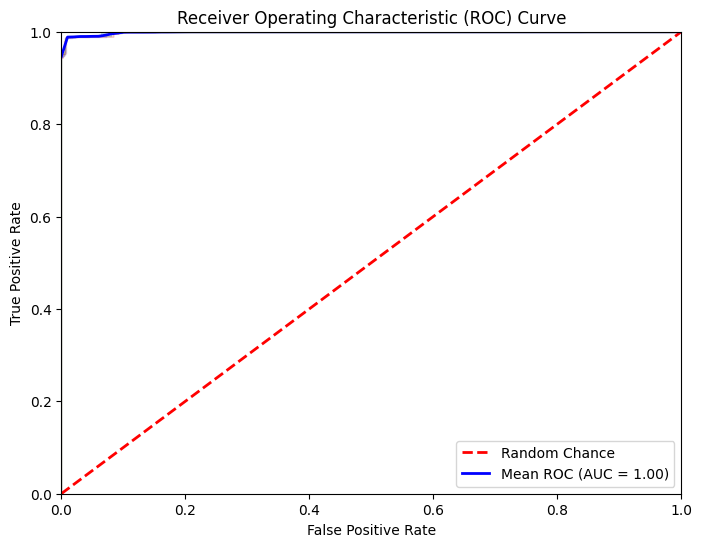

In [26]:
plot_roc_curve(rf, X, y)

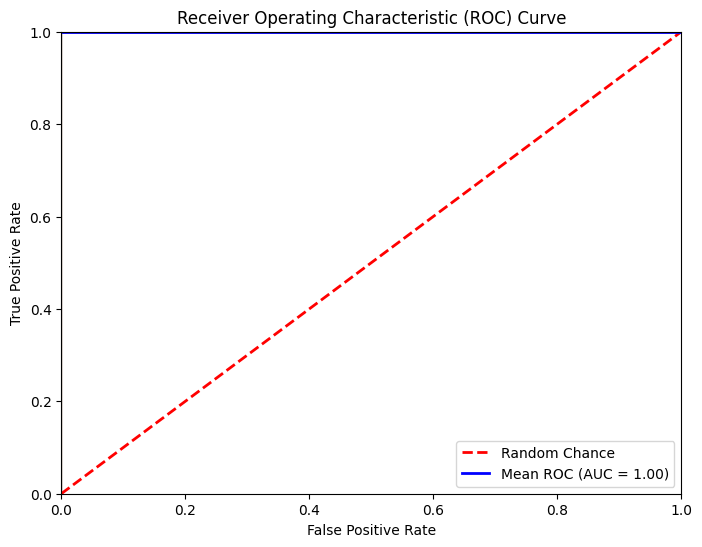

In [27]:
plot_roc_curve(xgb, X, y)